# Predicting Terrorist Attacks
## Perpetrator Classification

**Author:** Thomas Skowronek

**Date:** April 07, 2018

### Notebook Configuration

In [71]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [72]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### Load the Datasets
Load the dataset created by the EDA notebook.

In [73]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_csv('../data/gtd_eda_95t016.csv', low_memory=False, index_col = 0,
                      na_values=[''])

### Inspect the Structure
The cleansed data frame contains 48 attributes, one of which is used for the data frame index, and 110,844 observations.

In [74]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null object
region_txt          110844 non-null object
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null float64
summary             110844 non-null object
attacktype1_txt     110844 non-null object
targtype1_txt       110844 non-null object
targsubtype1_txt    110844 non-null object
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null object
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null object
weapsubtype

### Convert Attributes to Correct Data Type
Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [75]:
# List of attributes that are categorical
cat_attrs = ['extended_txt', 'country_txt', 'region_txt', 'specificity', 'vicinity_txt',
             'crit1_txt', 'crit2_txt', 'crit3_txt', 'doubtterr_txt', 'multiple_txt',
             'success_txt', 'suicide_txt', 'attacktype1_txt', 'targtype1_txt', 
             'targsubtype1_txt', 'natlty1_txt', 'guncertain1_txt', 'individual_txt', 
             'claimed_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'property_txt', 
             'ishostkid_txt', 'INT_LOG_txt', 'INT_IDEO_txt','INT_MISC_txt', 'INT_ANY_txt']

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for label encoding below
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110844 entries, 199501000001 to 201701270001
Data columns (total 48 columns):
iyear               110844 non-null int64
imonth              110844 non-null int64
iday                110844 non-null int64
country_txt         110844 non-null category
region_txt          110844 non-null category
provstate           110844 non-null object
city                110844 non-null object
latitude            110844 non-null float64
longitude           110844 non-null float64
specificity         110844 non-null category
summary             110844 non-null object
attacktype1_txt     110844 non-null category
targtype1_txt       110844 non-null category
targsubtype1_txt    110844 non-null category
corp1               110844 non-null object
target1             110844 non-null object
natlty1_txt         110844 non-null category
gname               110844 non-null object
nperpcap            110844 non-null float64
weaptype1_txt       110844 non-null categ

### Find the Major Groups
Get the list of terrorist groups that have 20 or more attacks.

In [76]:
# Calculate the number of attacks by group
groups = gtd_df['gname'].value_counts()

# Include groups with at least 20 attacks
groups = groups[groups > 19]

# Exclude unknown groups
#group_list = groups.index[groups.index != 'Unknown']
group_list = groups.index

# Subset the data to major groups
major_groups = gtd_df[gtd_df['gname'].isin(group_list)]

# Display the number of attacks by group
major_groups['gname'].value_counts()

Unknown                                                         59531
Taliban                                                          6558
Islamic State of Iraq and the Levant (ISIL)                      4261
Al-Shabaab                                                       2669
Boko Haram                                                       2067
Communist Party of India - Maoist (CPI-Maoist)                   1766
Revolutionary Armed Forces of Colombia (FARC)                    1529
New People's Army (NPA)                                          1444
Maoists                                                          1411
Kurdistan Workers' Party (PKK)                                   1255
Tehrik-i-Taliban Pakistan (TTP)                                  1250
Al-Qaida in the Arabian Peninsula (AQAP)                          966
Liberation Tigers of Tamil Eelam (LTTE)                           950
Houthi extremists (Ansar Allah)                                   862
Al-Qaida in Iraq    

### Drop Text and Datetime Attributes
Remove the text and datetime attributes, which will not be used in the models.

In [77]:
major_groups = major_groups.drop(['provstate', 'city', 'summary', 'corp1', 'target1',
                                  'scite1', 'dbsource', 'incident_date'], axis=1)

major_groups.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106144 entries, 199501000001 to 201612310044
Data columns (total 40 columns):
iyear               106144 non-null int64
imonth              106144 non-null int64
iday                106144 non-null int64
country_txt         106144 non-null category
region_txt          106144 non-null category
latitude            106144 non-null float64
longitude           106144 non-null float64
specificity         106144 non-null category
attacktype1_txt     106144 non-null category
targtype1_txt       106144 non-null category
targsubtype1_txt    106144 non-null category
natlty1_txt         106144 non-null category
gname               106144 non-null object
nperpcap            106144 non-null float64
weaptype1_txt       106144 non-null category
weapsubtype1_txt    106144 non-null category
nkill               106144 non-null float64
nkillus             106144 non-null float64
nkillter            106144 non-null float64
nwound              106144 non-nul

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [78]:
scaler = preprocessing.RobustScaler()

# List of numeric attributes
scale_attrs = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

# Standardize the attributes in place
major_groups[scale_attrs] = scaler.fit_transform(major_groups[scale_attrs])

# View the transformation
major_groups[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nperpcap,106144.0,0.093185,1.766333,0.0,0.0,0.0,0.0,406.000000
nkill,106144.0,0.726518,5.881224,-0.5,-0.5,0.0,0.5,749.500000
nkillus,106144.0,0.039559,5.881791,0.0,0.0,0.0,0.0,1358.000000
nkillter,106144.0,0.438310,4.068101,0.0,0.0,0.0,0.0,500.000000
nwound,106144.0,1.181134,12.390895,0.0,0.0,0.0,1.0,2455.333333
nwoundus,106144.0,0.020416,2.125241,0.0,0.0,0.0,0.0,650.000000
nwoundte,106144.0,0.089256,1.410185,0.0,0.0,0.0,0.0,200.000000


### Separate Known and Unknown
Split the major groups into known and unknown.

In [79]:
# Excluded Unknown groups
known_maj_groups = major_groups[gtd_df['gname'] != "Unknown"]
print("Known Major Groups: {}".format(known_maj_groups.shape))

# Only include Unknown groups
unknown_maj_groups = major_groups[gtd_df['gname'] == "Unknown"]
print("Unknown Major Groups: {}".format(unknown_maj_groups.shape))

Known Major Groups: (46613, 40)
Unknown Major Groups: (59531, 40)


### Encode the Target Attribute
Convert the text values of the terrorist groups to an encoded numeric value for the random forest models.

In [80]:
# Create the encoder
le = preprocessing.LabelEncoder()

# Fit the encoder to the target
le.fit(known_maj_groups['gname'])

LabelEncoder()

In [81]:
# View the labels
list(le.classes_)

['Abdullah Azzam Brigades',
 'Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Ahrar al-Sham',
 'Ajnad Misr',
 'Al-Aqsa Martyrs Brigade',
 'Al-Fatah',
 "Al-Gama'at al-Islamiyya (IG)",
 'Al-Naqshabandiya Army',
 'Al-Nusrah Front',
 'Al-Qaida',
 'Al-Qaida in Iraq',
 'Al-Qaida in the Arabian Peninsula (AQAP)',
 'Al-Qaida in the Islamic Maghreb (AQIM)',
 'Al-Shabaab',
 'Albanian extremists',
 'Algerian Islamic Extremists',
 'Allied Democratic Forces (ADF)',
 'Anarchists',
 'Animal Liberation Front (ALF)',
 'Ansar Bayt al-Maqdis (Ansar Jerusalem)',
 'Ansar al-Dine (Mali)',
 'Ansar al-Islam',
 'Ansar al-Sharia (Libya)',
 'Anti-Abortion extremists',
 'Anti-Balaka Militia',
 'Anti-Government extremists',
 'Anti-Muslim extremists',
 'Anti-Semitic extremists',
 'Armed Islamic Group (GIA)',
 "Asa'ib Ahl al-Haqq",
 'Awami League',
 'Azawad National Liberation Movement (MNLA)',
 'Baloch Liberation Army (BLA)',
 'Baloch Liberation Front (BLF)',
 'Baloch Nationalists',
 'Baloch

In [82]:
# View the encoded values for th terrorist group names
label_codes = le.transform(known_maj_groups['gname'])
label_codes

array([ 24,  24,  24, ..., 200,  43, 116])

In [83]:
# Convert some integers into their category names
list(le.inverse_transform([0, 1, 2, 27]))

['Abdullah Azzam Brigades',
 'Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Anti-Muslim extremists']

### Create Training and Testing Datasets
The original dataset is split into 80% training and 20% testing.

In [84]:
# Seed for reproducible results
seed = 1009

# Predictor variables
X = pd.get_dummies(known_maj_groups.drop(['gname'], axis=1), drop_first=True)

# Labels
y = label_codes

# Create an 80/20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

### Random Forest Model
Create the model using 1000 estimators.

In [85]:
start = time.time()

# Create the model
rf1 = RandomForestClassifier(n_estimators = 1000, oob_score = True, n_jobs = -1, random_state = seed)

# Fit it to the training data
rf1.fit(X_train, y_train)

end = time.time()
print("Execution Seconds: {}".format((end - start)))
print("\n")
print(rf1)

Execution Seconds: 163.3958101272583


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=1009, verbose=0, warm_start=False)


### Feature Importance
Display the top 50 features by importance in descending order.

In [86]:
# Get the modified column names with one hot encoding
column_names = list(X_train.columns.values)

# Create a descending sorted list of variables by featur importance
var_imp = sorted(zip(map(lambda x: x, rf1.feature_importances_), column_names), 
             reverse = True)

print("\nFeatures Ranking - Top 50:\n")
for f in var_imp[0:50]:
    print(f)


Features Ranking - Top 50:

(0.090610911185397228, 'longitude')
(0.083954438743832377, 'latitude')
(0.043483756997256352, 'iyear')
(0.027691347890146083, 'region_txt_South Asia')
(0.020542442864198204, 'INT_ANY_txt_YES')
(0.020472018264479187, 'INT_IDEO_txt_YES')
(0.019689082832654241, 'country_txt_Iraq')
(0.019204650188159301, 'iday')
(0.0186233206889303, 'region_txt_Middle East & North Africa')
(0.018312949801860115, 'imonth')
(0.01796840599946959, 'country_txt_Somalia')
(0.017826924906577581, 'natlty1_txt_Iraq')
(0.014905832405740093, 'region_txt_Sub-Saharan Africa')
(0.014600956795743695, 'INT_IDEO_txt_UKNOWN')
(0.01449914516069721, 'INT_LOG_txt_UKNOWN')
(0.014341933733816589, 'nkill')
(0.014124991750796529, 'INT_ANY_txt_UKNOWN')
(0.01278521064019564, 'country_txt_Pakistan')
(0.012443160980158798, 'country_txt_India')
(0.012165962613075542, 'natlty1_txt_Pakistan')
(0.011929074011110962, 'natlty1_txt_India')
(0.011803792421003724, 'nwound')
(0.011771647569482803, 'country_txt_Niger

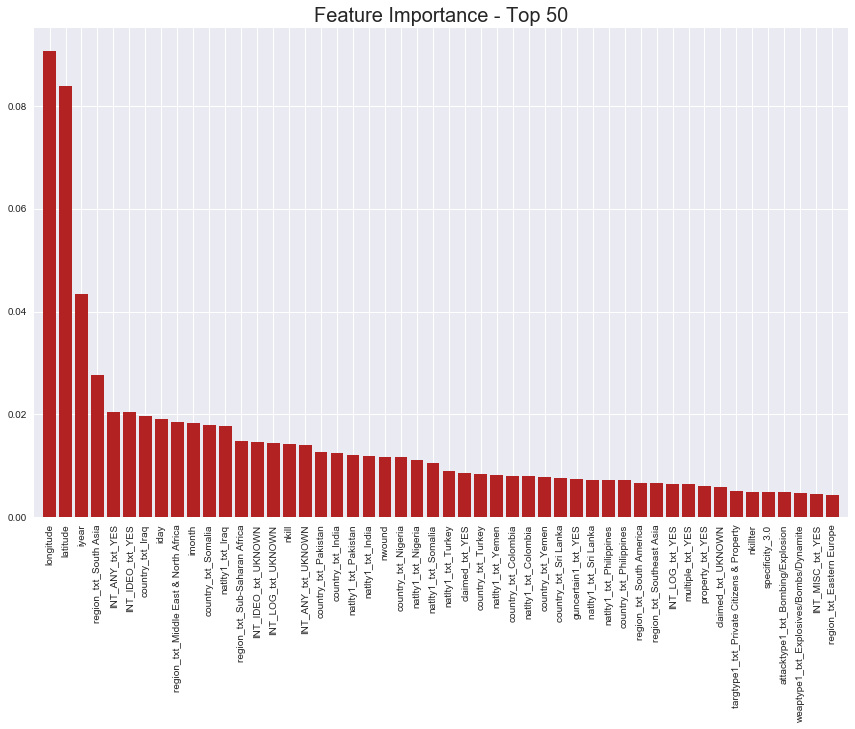

In [92]:
# Get the features, standard deviation and indices
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter to the top 50
top_n = 50
top_n_importances = importances[indices][0:top_n]
top_n_std = std[0:top_n]
top_n_indices = indices[0:top_n]

# Create a list of x labels
x_labels = [column_names[t] for t in top_n_indices]

# Plot the results
plt.figure()
plt.title("Feature Importance - Top 50",  fontsize=20)
plt.bar(range(top_n), top_n_importances, color="firebrick", yerr = top_n_std, align="center")
plt.xticks(rotation=90)
plt.xticks(range(top_n), x_labels)
plt.xlim([-1, top_n])
plt.show()

In [88]:
# Predict labels on the test dataset
pred_labels1 = rf1.predict(X_test)

# Calculate the accuracy of the model
acc_score1 = accuracy_score(y_test, pred_labels1)
print("\nAccuracy: {}".format(acc_score1))

# Calculate the precision of the model
prec_score1 = precision_score(y_test, pred_labels1, average='weighted')
print("\nPrecision: {}".format(prec_score1))

# Calculate the recall of the model
rcll_score1 = recall_score(y_test, pred_labels1, average='weighted')
print("\nRecall: {}".format(rcll_score1))

# Calculate the F1 of the model
f1_score1 = f1_score(y_test, pred_labels1, average='weighted')
print("\nF1: {}".format(f1_score1))


Accuracy: 0.9045371661482355

Precision: 0.902580366378236

Recall: 0.9045371661482355

F1: 0.895149376819738


### Apply Model to Uknown Groups
Of the 106,544 observations, 56.25% have a group classification of Unknown.

In [89]:
# Predictor variables
X_unknown = pd.get_dummies(unknown_maj_groups.drop(['gname'], axis=1), drop_first=True)


# Predict labels on the unknown dataset
pred_labels2 = rf1.predict(X_unknown)

# Get the list of predicted labels for unknown observations
unknown_preds = list(le.inverse_transform(pred_labels2))

# Calculate the counts for each group
unknown_counts = collections.Counter(unknown_preds)

### Top 25 Predicted Unknown Groups
The top 25 predicted groups account for 97.59% of the unknown observations.

In [90]:
# Top 25 unknown
unknown_top25 = pd.DataFrame(unknown_counts.most_common()[0:25], columns=['Group', 'Attacks'])

cumsum = 0

# Display the top 25 groups with counts
for index, row in unknown_top25.iterrows():
    print("{} : {}".format(row['Group'], row['Attacks']))
    cumsum += row['Attacks']


print("\nTop 25 Account For: {}%".format((cumsum / X_unknown.shape[0])*100))

Muslim extremists : 24564
Gunmen : 8568
Separatists : 3677
Tribesmen : 3490
Militants : 3430
Maoists : 2303
Taliban : 1868
Sunni Muslim extremists : 1461
Taliban (Pakistan) : 1226
Fulani extremists : 908
Islamist extremists : 883
New People's Army (NPA) : 871
Anarchists : 826
Opposition Group : 705
Neo-Nazi extremists : 551
Protestant extremists : 534
Left-Wing Guerrillas : 392
Muslim Separatists : 380
Kurdistan Workers' Party (PKK) : 320
Al-Shabaab : 214
Liberation Tigers of Tamil Eelam (LTTE) : 208
Chechen Rebels : 207
Rebels : 185
Paramilitaries : 174
Anti-Abortion extremists : 156

Top 25 Account For: 97.59789017486688%


### Muslim Extremists
Almost half of the predicted unknown group observations are Muslim extremists.

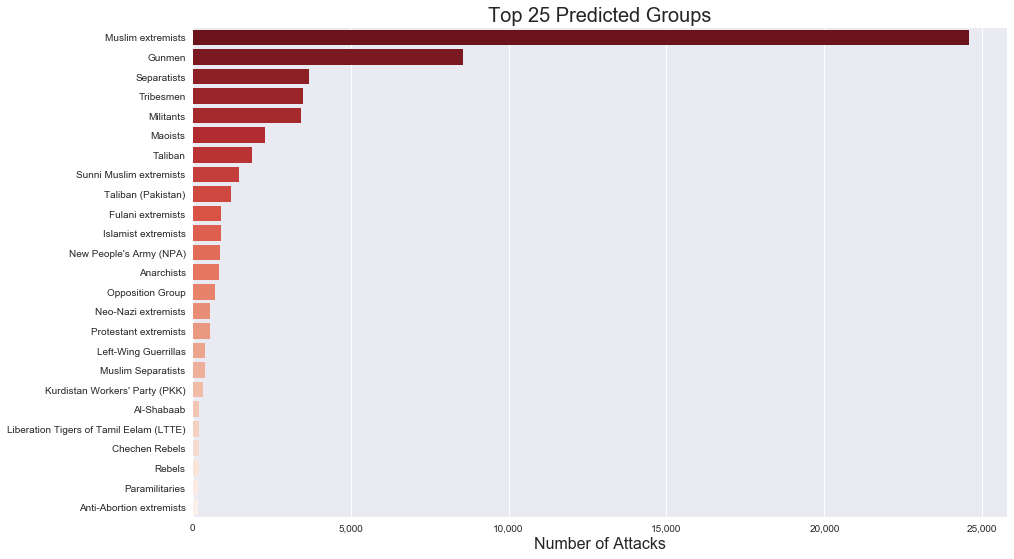

In [91]:
# Set the color palette in reverse
colors = sns.color_palette('Reds', len(unknown_top25))
colors.reverse()
plt.figure(figsize=(14.6, 9.0))

# Plot bar chart with index as y values
ax = sns.barplot(unknown_top25.Attacks, unknown_top25.index, orient='h', palette=colors)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Reset the y labels
ax.set_yticklabels(unknown_top25.Group)
ax.set_xlabel(xlabel='Number of Attacks', fontsize=16)
ax.set_title(label='Top 25 Predicted Groups', fontsize=20)
plt.show();

### References

Albon, C. (2017). Convert Pandas categorical data for scikit-learn Retrieved from https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

Keen, B. (2017). Feature scaling with scikit-learn Retrieved from http://benalexkeen.com/feature-scaling-with-scikit-learn/

Saabas, A. (2014). Selecting good features – Part III: random forests Retrieved from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

scikit-learn. (n.d.). Feature importances with forests of trees Retrieved from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py